# 04 - Report Figures

Generate figures for the executive summary.


## Overview

- Load `data/processed/merged.csv`
- Create: (1) boxplot returns by sector, (2) returns vs sentiment bins, (3) PCA scatter
- Save figures to `reports/figures/` with `src.plot.savefig` (dpi=150)


## Imports and Data Load


In [104]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from src.utils import read_csv_safe, validate_columns
from src.plot import savefig

# Resolve project root so paths are correct when running from notebooks/
def _resolve_root() -> Path:
    candidates = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
    for base in candidates:
        if (base / "pyproject.toml").exists() and (base / "data").exists():
            return base
    return Path.cwd()

PROJECT_ROOT = _resolve_root()
MERGED_PATH = PROJECT_ROOT / "data/processed/merged.csv"

df = read_csv_safe(MERGED_PATH, parse_dates=["date"]) if MERGED_PATH.exists() else pd.DataFrame()
if not df.empty:
    validate_columns(df, [
        "date","ticker","sector","close","volume","volatility","return","sentiment_score","n_headlines"
    ])

# Prepare sentiment bins for figure 2
if not df.empty and "sentiment_score" in df.columns:
    def _bin(x: float) -> str:
        if x <= -0.2:
            return "neg"
        if x >= 0.2:
            return "positive"
        return "neutral"
    df["sentiment_bin"] = df["sentiment_score"].apply(_bin)


## Figure 1: Boxplot of Returns by Sector


/var/folders/sh/sd90d7g915z_45qpzn7ftbh00000gn/T/ipykernel_39347/3142751985.py:77: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



Enhanced boxplot saved: figure_returns_by_sector_enhanced


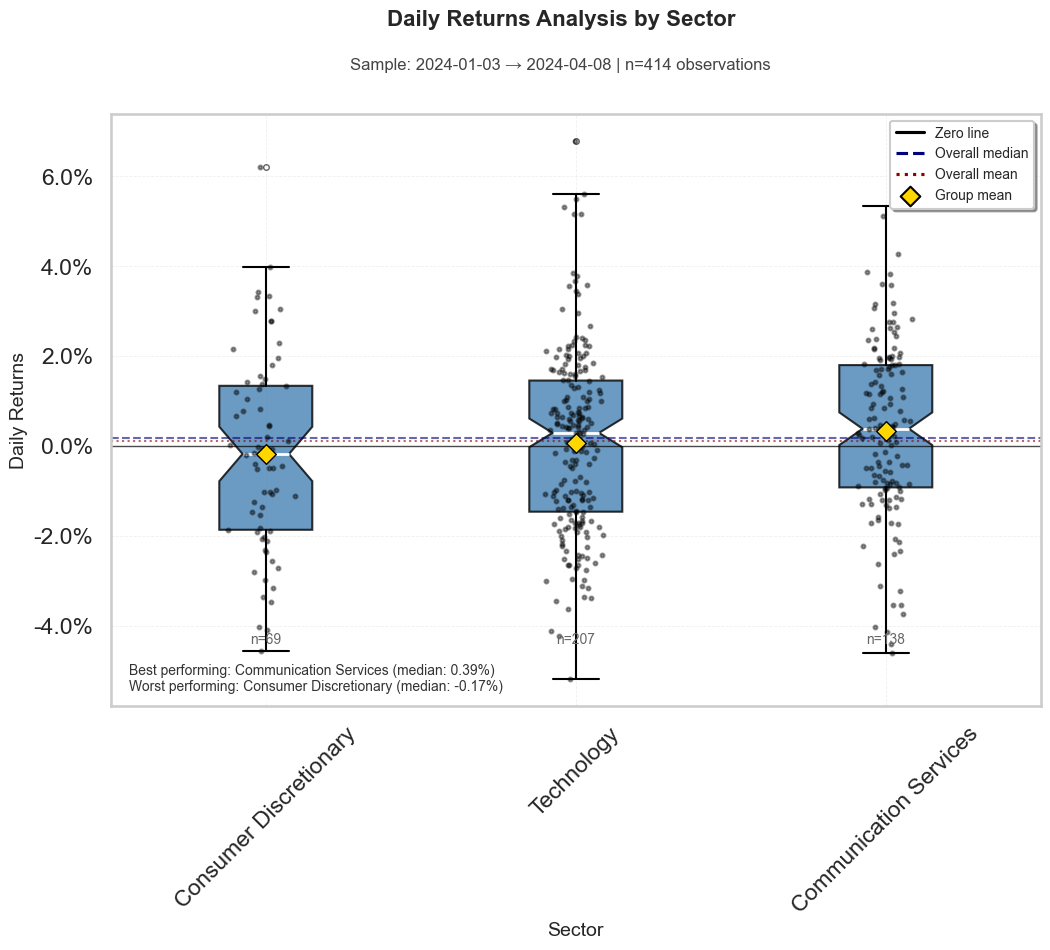

In [ ]:
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib.patches import Patch

def create_enhanced_boxplot(
    df: pd.DataFrame,
    value_col: str = "return",
    group_col: str = "sector",
    title: str = "Returns Analysis by Sector",
    filename: str = "figure_returns_by_sector"
) -> None:
    
    # Data preparation
    plot_data = _prepare_boxplot_data(df, value_col, group_col)
    if plot_data is None:
        return
    
    # Create plot
    fig, ax = _create_boxplot_base()
    
    # Main visualization
    _add_enhanced_boxplot(ax, plot_data, value_col, group_col)
    _add_statistical_overlays(ax, plot_data, value_col, group_col)
    _add_statistical_annotations(ax, plot_data, value_col, group_col)
    
    # Styling and annotations
    _style_boxplot(ax, fig, title, plot_data, value_col, group_col)
    _add_boxplot_summary(ax, plot_data, value_col, group_col)
    
    # Save
    _save_boxplot_plots(fig, filename)


def _prepare_boxplot_data(df: pd.DataFrame, value_col: str, group_col: str) -> pd.DataFrame:
    """Prepare and validate data for boxplot."""
    if df.empty:
        print(f"No data available for {group_col} boxplot")
        return None
    
    # Filter out missing values
    plot_data = df[[value_col, group_col, "date"]].dropna()
    
    if plot_data.empty or plot_data[group_col].nunique() < 2:
        print(f"Insufficient data for {group_col} boxplot")
        return None
    
    return plot_data


def _create_boxplot_base() -> tuple:
    """Create base figure and axes"""
    sns.set_context("talk")
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 8))
    return fig, ax


def _add_enhanced_boxplot(ax, data: pd.DataFrame, value_col: str, group_col: str) -> None:
    """Add main boxplot with enhancements."""
    # Calculate median for each group to determine color coding
    group_medians = data.groupby(group_col)[value_col].median().sort_values()
    
    # Create color palette based on performance
    n_groups = len(group_medians)
    colors = []
    for median in group_medians.values:
        if median > 0.005:  # Positive performance (green)
            colors.append('#2E8B57')  # Sea green
        elif median < -0.005:  # Negative performance (red)
            colors.append('#DC143C')  # Crimson
        else:  # Neutral performance (blue)
            colors.append('#4682B4')  # Steel blue
    
    # Create boxplot with custom colors
    box_plot = ax.boxplot(
        [data[data[group_col] == group][value_col].values for group in group_medians.index],
        labels=group_medians.index,
        patch_artist=True,
        notch=True,  # Add confidence intervals around median
        showfliers=True,
        flierprops=dict(marker='o', markersize=4, alpha=0.6),
        medianprops=dict(color='white', linewidth=2),
        boxprops=dict(linewidth=1.5, alpha=0.8),
        whiskerprops=dict(linewidth=1.5),
        capprops=dict(linewidth=1.5)
    )
    
    # Apply colors to boxes
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)


def _add_statistical_overlays(ax, data: pd.DataFrame, value_col: str, group_col: str) -> None:
    """Add statistical overlays: means, individual points, and distributions."""
    group_medians = data.groupby(group_col)[value_col].median().sort_values()
    
    # Add strip plot for individual data points
    for i, group in enumerate(group_medians.index, 1):
        group_data = data[data[group_col] == group][value_col].values
        
        # Add jittered points
        x_jitter = np.random.normal(i, 0.04, size=len(group_data))
        ax.scatter(x_jitter, group_data, alpha=0.4, s=8, color='black', zorder=3)
        
        # Add mean marker (diamond)
        mean_val = group_data.mean()
        ax.scatter(i, mean_val, marker='D', s=100, color='gold', 
                  edgecolor='black', linewidth=1, zorder=4, label='Mean' if i == 1 else '')


def _add_statistical_annotations(ax, data: pd.DataFrame, value_col: str, group_col: str) -> None:
    """Add statistical annotations: sample sizes, reference lines."""
    group_medians = data.groupby(group_col)[value_col].median().sort_values()
    
    # Add sample sizes below each box
    for i, group in enumerate(group_medians.index, 1):
        n_samples = len(data[data[group_col] == group])
        y_min = ax.get_ylim()[0]
        ax.text(i, y_min + 0.1 * (ax.get_ylim()[1] - y_min), f'n={n_samples}', 
               ha='center', va='bottom', fontsize=10, color='#666')
    
    # Add reference lines
    overall_median = data[value_col].median()
    overall_mean = data[value_col].mean()
    
    ax.axhline(0, color='black', alpha=0.7, linewidth=1, linestyle='-', 
              label='Zero line')
    ax.axhline(overall_median, color='navy', alpha=0.6, linewidth=1.5, 
              linestyle='--', label=f'Overall median ({overall_median:.3f})')
    ax.axhline(overall_mean, color='darkred', alpha=0.6, linewidth=1.5, 
              linestyle=':', label=f'Overall mean ({overall_mean:.3f})')


def _style_boxplot(ax, fig, title: str, data: pd.DataFrame, value_col: str, group_col: str) -> None:
    """Apply consistent styling to the boxplot."""
    # Format y-axis as percentages
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
    
    # Labels and title
    ax.set_xlabel(group_col.title(), fontsize=14)
    ax.set_ylabel('Daily Returns', fontsize=14)
    
    # Title and subtitle
    subtitle = ""
    if "date" in data.columns:
        dates = pd.to_datetime(data["date"])
        subtitle = f"Sample: {dates.min().date()} → {dates.max().date()} | n={len(data):,} observations"
    
    fig.subplots_adjust(top=0.85)
    fig.suptitle(title, y=0.98, fontsize=16, fontweight='bold')
    if subtitle:
        fig.text(0.5, 0.92, subtitle, ha="center", va="top", fontsize=12, color="#444")
    
    # Grid and styling
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.6)
    ax.set_axisbelow(True)
    
    # Rotate x-labels if needed
    labels = ax.get_xticklabels()
    if any(len(label.get_text()) > 8 for label in labels):
        ax.tick_params(axis='x', rotation=45)


def _add_boxplot_summary(ax, data: pd.DataFrame, value_col: str, group_col: str) -> None:
    """Add summary statistics and legend."""
    # Create custom legend
    legend_elements = [
        plt.Line2D([0], [0], color='black', linestyle='-', label='Zero line'),
        plt.Line2D([0], [0], color='navy', linestyle='--', label='Overall median'),
        plt.Line2D([0], [0], color='darkred', linestyle=':', label='Overall mean'),
        plt.scatter([], [], marker='D', s=100, color='gold', edgecolor='black', label='Group mean')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', frameon=True, 
             fancybox=True, shadow=True, fontsize=10)
    
    # Add interpretation text
    group_stats = data.groupby(group_col)[value_col].agg(['count', 'mean', 'median', 'std'])
    best_performer = group_stats['median'].idxmax()
    worst_performer = group_stats['median'].idxmin()
    
    interpretation = (f"Best performing: {best_performer} "
                     f"(median: {group_stats.loc[best_performer, 'median']:.2%})\n"
                     f"Worst performing: {worst_performer} "
                     f"(median: {group_stats.loc[worst_performer, 'median']:.2%})")
    
    ax.text(0.02, 0.02, interpretation, transform=ax.transAxes, 
           fontsize=10, color='#333', va='bottom', ha='left',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))


def _save_boxplot_plots(fig, filename: str) -> None:
    """Save boxplot in multiple formats."""
    savefig(PROJECT_ROOT / f"reports/figures/{filename}.png", fig=fig, dpi=300)
    savefig(PROJECT_ROOT / f"reports/figures/{filename}.pdf", fig=fig, dpi=300)
    print(f"Enhanced boxplot saved: {filename}")


# Generate enhanced figure 1
create_enhanced_boxplot(df, "return", "sector", "Daily Returns Analysis by Sector", "figure_returns_by_sector_enhanced")


## Figure 2: Returns vs Sentiment Bins


/var/folders/sh/sd90d7g915z_45qpzn7ftbh00000gn/T/ipykernel_39347/3157974703.py:77: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



Enhanced boxplot saved: figure_returns_vs_sentiment_bins_enhanced


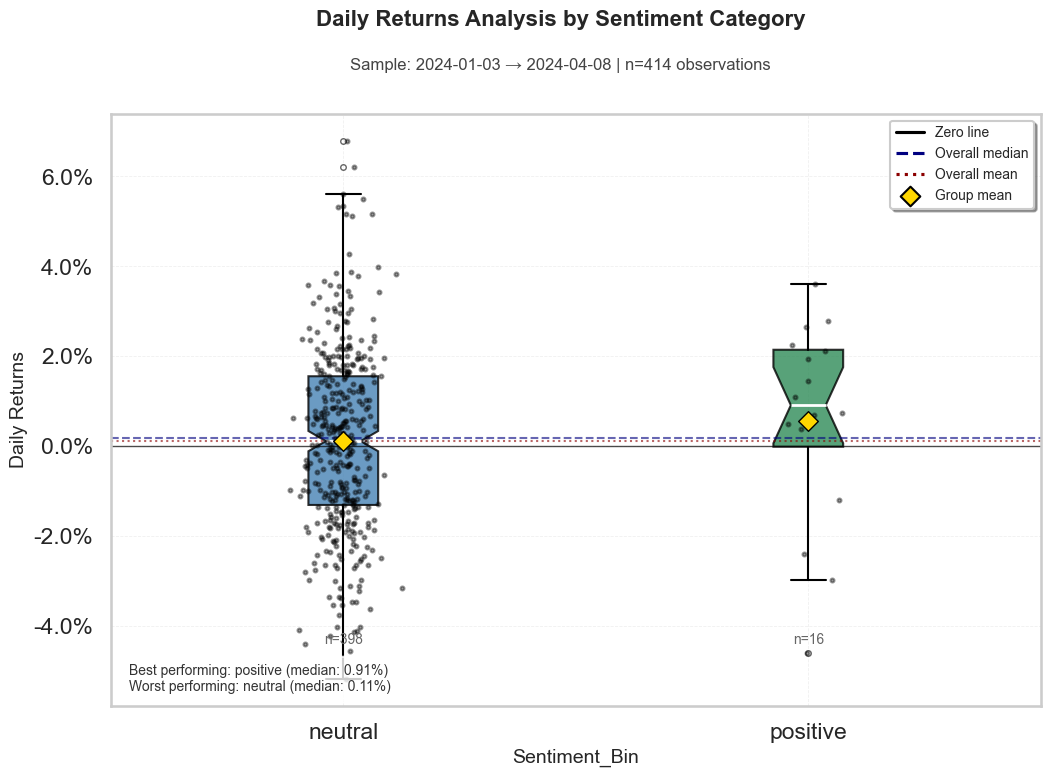

In [107]:
# Generate enhanced figure 2
if not df.empty and "sentiment_bin" in df.columns:
    create_enhanced_boxplot(
        df, 
        value_col="return", 
        group_col="sentiment_bin", 
        title="Daily Returns Analysis by Sentiment Category",
        filename="figure_returns_vs_sentiment_bins_enhanced"
    )
else:
    print("No sentiment bin data available for enhanced boxplot")


## Figure 3: PCA Scatter (2D)


/var/folders/sh/sd90d7g915z_45qpzn7ftbh00000gn/T/ipykernel_39347/1662444434.py:127: UserWarning:

The palette list has more values (8) than needed (3), which may not be intended.



{'pca_var_pc1': 0.31230771398881724, 'pca_var_pc2': 0.25425454707082723, 'pca_var_total': 0.5665622610596445, 'top_pc1_features': ['volatility', 'sentiment_score', 'volume'], 'top_pc2_features': ['return', 'sentiment_score', 'volume']}
Interpretation:
- PC1 is primarily driven by: volatility, sentiment_score, volume
- PC2 is primarily driven by: return, sentiment_score, volume


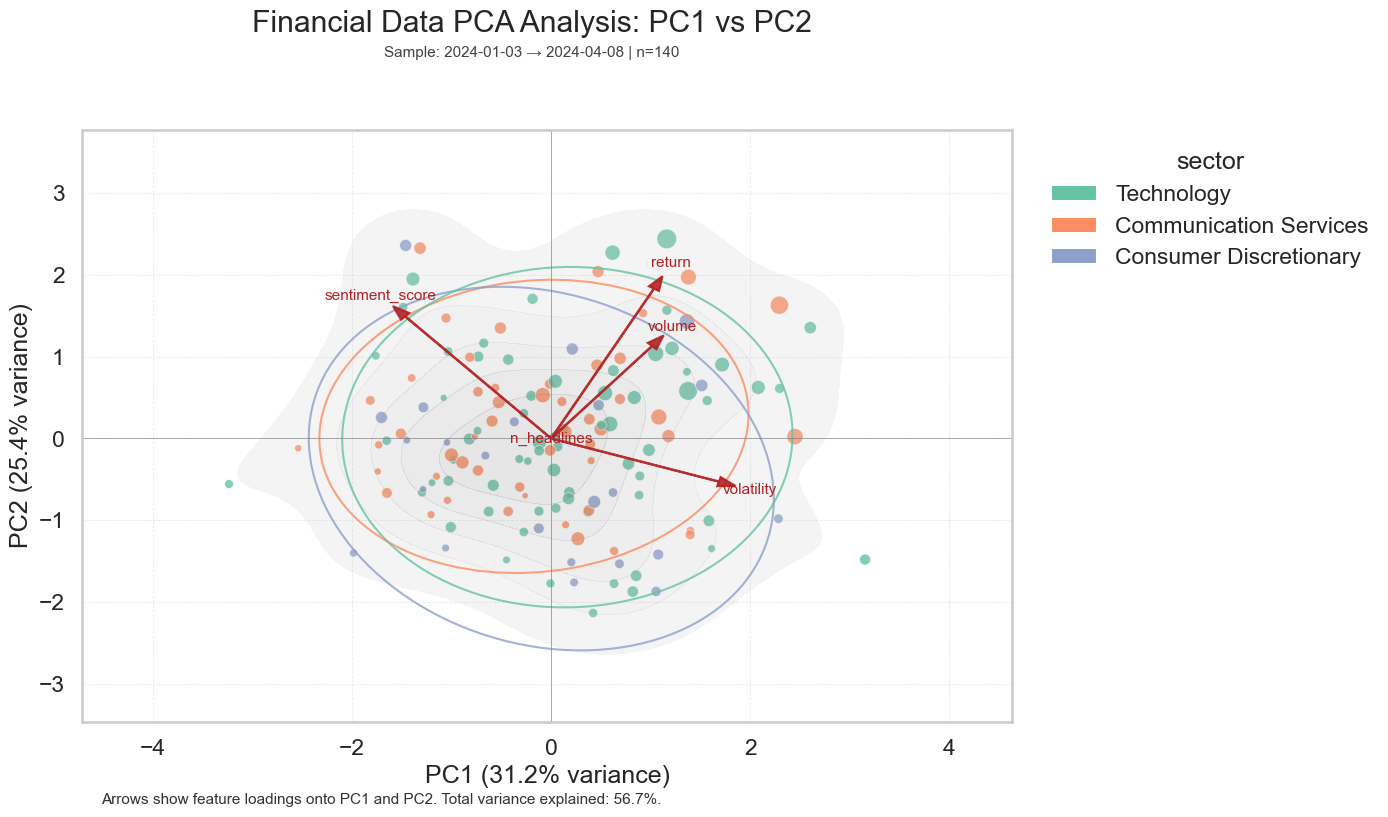

In [108]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional
from matplotlib.patches import Ellipse, Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def create_enhanced_pca_plot(df: pd.DataFrame) -> None:
    """Create an enhanced PCA biplot with loadings, categories, and styling."""
    if df.empty:
        print("No data available for PCA")
        return
    
    # Data preparation
    feat_cols = ["return", "volume", "volatility", "sentiment_score", "n_headlines"]
    X = df[feat_cols].dropna()
    
    if X.empty or len(X) < 10:
        print("PCA skipped: insufficient data after cleaning")
        return
    
    # Keep aligned metadata for visualization
    meta = df.loc[X.index].copy()
    
    # Determine color grouping variable
    color_col = _determine_color_column(meta)
    
    # Scale point sizes by volume
    point_sizes = _calculate_point_sizes(meta)
    
    # Fit PCA model
    pca_results = _fit_pca_model(X, feat_cols)
    
    # Create the plot
    fig, ax = _create_base_plot()
    
    # Add main scatter plot
    _add_scatter_plot(ax, pca_results, meta, color_col, point_sizes)
    
    # Add visualization enhancements
    _add_density_contours(ax, pca_results['components'])
    _add_confidence_ellipses(ax, pca_results, meta, color_col)
    _add_loading_vectors(ax, pca_results)
    
    # Style and annotate the plot
    _style_plot(ax, fig, pca_results, meta)
    _add_legend(ax, meta, color_col)
    _add_annotations(ax, pca_results)
    
    # Print summary and save
    _print_pca_summary(pca_results)
    _save_plots(fig)


def _determine_color_column(meta: pd.DataFrame) -> Optional[str]:
    """Determine which column to use for color coding."""
    if "sector" in meta.columns and meta["sector"].nunique() > 1:
        return "sector"
    else:
        # Create volatility regimes as fallback
        if "volatility" in meta.columns:
            meta["vol_regime"] = pd.qcut(
                meta["volatility"], q=3, 
                labels=["Low vol", "Med vol", "High vol"]
            )
        else:
            meta["vol_regime"] = "All"
        return "vol_regime"


def _calculate_point_sizes(meta: pd.DataFrame) -> np.ndarray:
    """Calculate scaled point sizes based on volume."""
    if "volume" not in meta.columns:
        return np.full(len(meta), 40.0)
    
    vol = meta["volume"].astype(float)
    vol_range = vol.max() - vol.min() + 1e-9
    return 20 + 80 * (vol - vol.min()) / vol_range


def _fit_pca_model(X: pd.DataFrame, feat_cols: list) -> dict:
    """Fit PCA model and return results."""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values)
    
    pca = PCA(n_components=2, random_state=42)
    components = pca.fit_transform(X_scaled)
    
    # Feature loadings (how much each feature contributes to each PC)
    loadings = pca.components_.T  # Shape: (n_features, 2)
    
    # Scale loading vectors for visualization
    max_score = np.max(np.abs(components))
    arrow_scale = 0.9 * max_score
    loading_vectors = loadings * arrow_scale
    
    return {
        'components': components,
        'loadings': loadings,
        'loading_vectors': loading_vectors,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'feature_names': np.array(feat_cols),
        'scaler': scaler,
        'pca': pca
    }


def _create_base_plot() -> tuple:
    """Create base figure and axes with styling."""
    sns.set_context("talk")
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 8))
    return fig, ax


def _add_scatter_plot(ax, pca_results: dict, meta: pd.DataFrame, 
                     color_col: str, point_sizes: np.ndarray) -> None:
    """Add the main scatter plot."""
    palette = sns.color_palette("Set2")
    components = pca_results['components']
    
    if color_col in meta.columns:
        sns.scatterplot(
            x=components[:, 0], y=components[:, 1],
            hue=meta[color_col].astype(str),
            size=point_sizes, sizes=(20, 200),
            palette=palette, edgecolor="white", linewidth=0.5,
            alpha=0.8, ax=ax, legend=False
        )
    else:
        ax.scatter(
            components[:, 0], components[:, 1], 
            s=point_sizes, alpha=0.8, 
            edgecolor="white", linewidth=0.5
        )


def _add_density_contours(ax, components: np.ndarray) -> None:
    """Add density contours to show data concentration."""
    try:
        sns.kdeplot(
            x=components[:, 0], y=components[:, 1], 
            levels=6, color="k", alpha=0.15, fill=True, ax=ax
        )
    except Exception:
        pass  # Skip if KDE fails


def _add_confidence_ellipse(ax, points: np.ndarray, color: str, n_std: float = 2.0) -> None:
    """Add confidence ellipse for a group of points."""
    if points.shape[0] < 5:
        return
    
    cov = np.cov(points.T)
    if not np.isfinite(cov).all():
        return
    
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    mean = points.mean(axis=0)
    
    ellipse = Ellipse(
        xy=mean, width=width, height=height, angle=theta,
        facecolor="none", edgecolor=color, linewidth=1.5, alpha=0.8
    )
    ax.add_patch(ellipse)


def _add_confidence_ellipses(ax, pca_results: dict, meta: pd.DataFrame, color_col: str) -> None:
    """Add confidence ellipses for each group."""
    if color_col not in meta.columns or meta[color_col].nunique() > 8:
        return
    
    palette = sns.color_palette("Set2")
    components = pca_results['components']
    X_index = meta.index
    
    labels_order = list(meta[color_col].astype(str).unique())
    
    for group, group_indices in meta.groupby(color_col).groups.items():
        # Convert DataFrame indices to positional indices
        pos_indices = X_index.get_indexer(group_indices)
        pos_indices = pos_indices[pos_indices >= 0]
        
        if pos_indices.size >= 5:  # Need enough points for ellipse
            color = palette[labels_order.index(str(group)) % len(palette)]
            _add_confidence_ellipse(ax, components[pos_indices], color)


def _add_loading_vectors(ax, pca_results: dict) -> None:
    """Add feature loading vectors as arrows."""
    loading_vectors = pca_results['loading_vectors']
    feature_names = pca_results['feature_names']
    arrow_scale = np.max(np.abs(pca_results['components'])) * 0.9
    
    for vector, name in zip(loading_vectors, feature_names):
        # Draw arrow
        ax.arrow(
            0, 0, vector[0], vector[1], 
            color="firebrick", alpha=0.9, 
            width=0.002 * arrow_scale,
            length_includes_head=True, 
            head_width=0.04 * arrow_scale
        )
        
        # Add label
        ax.text(
            vector[0] * 1.08, vector[1] * 1.08, name,
            color="firebrick", fontsize=11, 
            ha="center", va="center"
        )


def _style_plot(ax, fig, pca_results: dict, meta: pd.DataFrame) -> None:
    """Apply styling to the plot."""
    evr = pca_results['explained_variance_ratio']
    
    # Axis labels with variance explained
    ax.set_xlabel(f"PC1 ({evr[0]*100:.1f}% variance)")
    ax.set_ylabel(f"PC2 ({evr[1]*100:.1f}% variance)")
    
    # Title and subtitle
    title = "Financial Data PCA Analysis: PC1 vs PC2"
    subtitle = ""
    if "date" in meta.columns:
        dates = pd.to_datetime(meta["date"])
        subtitle = f"Sample: {dates.min().date()} → {dates.max().date()} | n={len(meta)}"
    
    fig.subplots_adjust(top=0.85)
    fig.suptitle(title, y=1)
    if subtitle:
        fig.text(0.5, 0.955, subtitle, ha="center", va="top", fontsize=11, color="#444")
    
    # Grid and reference lines
    ax.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.4)
    ax.axhline(0, color="#777", linewidth=0.7, alpha=0.6)
    ax.axvline(0, color="#777", linewidth=0.7, alpha=0.6)


def _add_legend(ax, meta: pd.DataFrame, color_col: str) -> None:
    """Add clean legend for color groups."""
    if color_col not in meta.columns:
        return
    
    palette = sns.color_palette("Set2")
    unique_labels = meta[color_col].astype(str).unique()
    
    legend_elements = [
        Patch(facecolor=palette[i % len(palette)], label=label) 
        for i, label in enumerate(unique_labels)
    ]
    
    ax.legend(
        handles=legend_elements, title=color_col,
        bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False
    )


def _add_annotations(ax, pca_results: dict) -> None:
    """Add explanatory annotations."""
    total_var = pca_results['explained_variance_ratio'][:2].sum()
    
    ax.text(
        0.02, -0.12,
        f"Arrows show feature loadings onto PC1 and PC2. "
        f"Total variance explained: {total_var*100:.1f}%.",
        transform=ax.transAxes, ha="left", va="top", 
        fontsize=11, color="#333"
    )


def _print_pca_summary(pca_results: dict) -> None:
    """Print PCA summary statistics."""
    evr = pca_results['explained_variance_ratio']
    loadings = pca_results['loadings']
    feature_names = pca_results['feature_names']
    
    # Top contributing features per PC
    top_pc1 = feature_names[np.argsort(np.abs(loadings[:, 0]))[::-1][:3]]
    top_pc2 = feature_names[np.argsort(np.abs(loadings[:, 1]))[::-1][:3]]
    
    print({
        "pca_var_pc1": float(evr[0]),
        "pca_var_pc2": float(evr[1]),
        "pca_var_total": float(evr[:2].sum()),
        "top_pc1_features": top_pc1.tolist(),
        "top_pc2_features": top_pc2.tolist(),
    })
    
    print("Interpretation:")
    print(f"- PC1 is primarily driven by: {', '.join(top_pc1)}")
    print(f"- PC2 is primarily driven by: {', '.join(top_pc2)}")


def _save_plots(fig) -> None:
    """Save plots in high resolution."""
    savefig(PROJECT_ROOT / "reports/figures/figure_pca_enhanced.png", fig=fig, dpi=300)
    savefig(PROJECT_ROOT / "reports/figures/figure_pca_enhanced.pdf", fig=fig, dpi=300)


# Execute the PCA analysis
create_enhanced_pca_plot(df)